# Task-1: Mushroom Classification
Implement a Naïve Bayes classifier for the Mushroom classification. Check out the enclosed metadata.
Divide the dataset into training and testing sets with 80% and 20% randomly selected records (without
replacement) respectively. Make sure to keep the classes balanced. Plot the confusion matrix and report
the performance in precision, recall, and F-1 scores.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics import confusion_matrix, classification_report


In [40]:
# Load dataset (replace 'mushrooms.csv' with your file name)
df  = pd.read_csv('mushrooms.csv')

# Peek at data
df.head()



,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [41]:
print(df['class'].value_counts())  # To check balance

class
e    4208
p    3916
Name: count, dtype: int64


In [62]:
def train_test_split(X, y, train_ratio=0.8, random_state=42):
    np.random.seed(random_state)  # for reproducibility
    
    # Get unique classes
    classes = np.unique(y)
    X_train, X_test, y_train, y_test = [], [], [], []
    
    for c in classes:
        # Get indices for each class
        idx = np.where(y == c)[0]
        np.random.shuffle(idx)
        
        split = int(len(idx) * train_ratio)
        train_idx, test_idx = idx[:split], idx[split:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)


In [43]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.feature_probs = {}
        self.classes = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        
        # Count class priors
        class_counts = Counter(y)
        self.class_priors = {c: class_counts[c] / n_samples for c in self.classes}
        
        # Conditional probabilities
        self.feature_probs = {c: [defaultdict(int) for _ in range(n_features)] for c in self.classes}
        
        for xi, label in zip(X, y):
            for j, feature_value in enumerate(xi):
                self.feature_probs[label][j][feature_value] += 1
        
        # Convert counts to probabilities with Laplace smoothing
        for c in self.classes:
            for j in range(n_features):
                total_count = sum(self.feature_probs[c][j].values())
                unique_values = len(self.feature_probs[c][j])
                for val in self.feature_probs[c][j]:
                    self.feature_probs[c][j][val] = (self.feature_probs[c][j][val] + 1) / (total_count + unique_values)
    
    def predict(self, X):
        predictions = []
        for xi in X:
            class_scores = {}
            for c in self.classes:
                # Start with log prior
                score = np.log(self.class_priors[c])
                for j, feature_value in enumerate(xi):
                    prob = self.feature_probs[c][j].get(feature_value, 1e-6)
                    score += np.log(prob)
                class_scores[c] = score
            predictions.append(max(class_scores, key=class_scores.get))
        return np.array(predictions)


In [44]:
# Features and labels
X = df.drop("class", axis=1).values
y = df["class"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.8)

# Train model
nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)

# Predict
y_pred = nb.predict(X_test)



Classification Report:

              precision    recall  f1-score   support

           e       0.99      1.00      0.99       842
           p       1.00      0.99      0.99       784

    accuracy                           0.99      1626
   macro avg       0.99      0.99      0.99      1626
weighted avg       0.99      0.99      0.99      1626



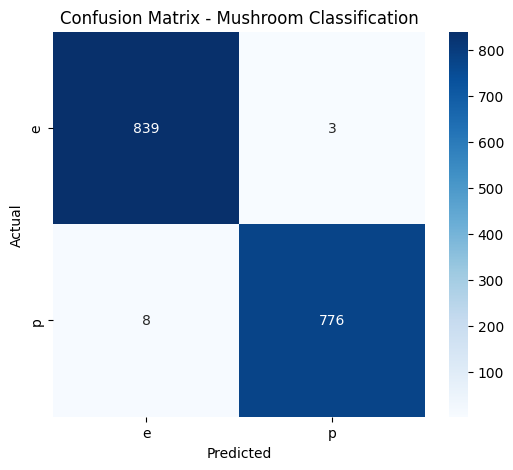

In [45]:

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

# Print classification report (precision, recall, F1)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=np.unique(y)))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), 
            yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Mushroom Classification")
plt.show()


# Task-2: Sentiment Classification
Implement a Naïve Bayes classifier for the movie reviews classification problem. Divide the dataset into
train-test sets with 70%-30% randomly selected records (without replacement) respectively. Make sure to
keep the classes balanced. Plot the confusion matrix and report the performance in precision, recall, and
F-1 scores.

In [51]:
df  = pd.read_csv('cleaned_reviews.csv')

In [55]:
import re
from collections import defaultdict

class SimpleCountVectorizer:
    def __init__(self):
        self.vocab = {}          # word -> index
        self.inverse_vocab = {}  # index -> word
    
    def tokenize(self, text):
        """
        Basic tokenizer:
        - Lowercases text
        - Keeps only words (letters/numbers)
        - Splits by spaces
        """
        text = text.lower()
        tokens = re.findall(r"\b\w+\b", text)
        return tokens
    
    def fit(self, documents):
        """
        Build vocabulary from a list of documents.
        documents: list/array of strings
        """
        vocab_set = set()
        for doc in documents:
            tokens = self.tokenize(doc)
            vocab_set.update(tokens)
        
        # assign index to each unique word
        self.vocab = {word: i for i, word in enumerate(sorted(vocab_set))}
        self.inverse_vocab = {i: word for word, i in self.vocab.items()}
    
    def transform(self, documents):
        """
        Transform documents into bag-of-words vectors.
        Each row = document, each column = word count.
        """
        vectors = []
        for doc in documents:
            tokens = self.tokenize(doc)
            vec = [0] * len(self.vocab)
            for token in tokens:
                if token in self.vocab:
                    idx = self.vocab[token]
                    vec[idx] += 1
            vectors.append(vec)
        return np.array(vectors)
    
    def fit_transform(self, documents):
        """
        Fit vocabulary and return bag-of-words vectors for training documents.
        """
        self.fit(documents)
        return self.transform(documents)


In [59]:
import numpy as np
from collections import defaultdict, Counter

class MultinomialNBFromScratch:
    def __init__(self, alpha=1.0):
        """
        Multinomial Naïve Bayes (with Laplace smoothing).
        alpha: smoothing parameter
        """
        self.alpha = alpha
        self.class_log_prior_ = {}    # log P(class)
        self.feature_log_probs_ = {}  # log P(word | class)
        self.classes_ = None
        self.vocab_size = 0

    def fit(self, X, y):
        """
        Train the Naïve Bayes classifier.
        X: numpy array (n_samples, n_features) -> bag-of-words
        y: numpy array (n_samples,) -> labels
        """
        n_samples, n_features = X.shape
        self.vocab_size = n_features
        self.classes_ = np.unique(y)

        # Count documents per class
        class_counts = Counter(y)
        total_docs = n_samples

        # log priors
        self.class_log_prior_ = {
            c: np.log(class_counts[c] / total_docs) for c in self.classes_
        }

        # Count words per class
        word_counts = {c: np.zeros(n_features) for c in self.classes_}
        for xi, label in zip(X, y):
            word_counts[label] += xi

        # Compute conditional probabilities with Laplace smoothing
        self.feature_log_probs_ = {}
        for c in self.classes_:
            total_count = np.sum(word_counts[c])
            # P(word|class) = (count(word,class)+alpha) / (total_words_in_class + alpha*vocab_size)
            probs = (word_counts[c] + self.alpha) / (total_count + self.alpha * self.vocab_size)
            self.feature_log_probs_[c] = np.log(probs)

    def predict(self, X):
        """
        Predict labels for given data.
        """
        predictions = []
        for xi in X:
            class_scores = {}
            for c in self.classes_:
                # log P(class) + sum(log P(word|class) * word_count)
                score = self.class_log_prior_[c] + np.sum(xi * self.feature_log_probs_[c])
                class_scores[c] = score
            # Pick the class with highest score
            predictions.append(max(class_scores, key=class_scores.get))
        return np.array(predictions)


In [63]:
# Use cleaned reviews and sentiment
X = df["cleaned_review"].values
y = df["sentiment"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_ratio=0.7,random_state=22
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


# Initialize and fit vectorizer
vectorizer = SimpleCountVectorizer()

# Convert text into bag-of-words vectors
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

print("Vocabulary size:", len(vectorizer.vocab))
print("X_train shape:", X_train_counts.shape)
print("X_test shape:", X_test_counts.shape)


Training samples: 3499
Testing samples: 1501
Vocabulary size: 33074
X_train shape: (3499, 33074)
X_test shape: (1501, 33074)


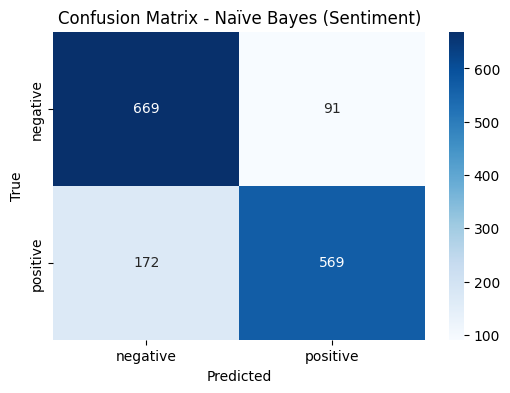

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.88      0.84       760
    positive       0.86      0.77      0.81       741

    accuracy                           0.82      1501
   macro avg       0.83      0.82      0.82      1501
weighted avg       0.83      0.82      0.82      1501



In [69]:

# -------------------------
# 1) Train the Naïve Bayes
# -------------------------
nb = MultinomialNBFromScratch(alpha=1.0)
nb.fit(X_train_counts, y_train)

# -------------------------
# 2) Predict on Test Data
# -------------------------
y_pred = nb.predict(X_test_counts)

# -------------------------
# 3) Evaluation
# -------------------------
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=nb.classes_)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Naïve Bayes (Sentiment)")
plt.show()

# Precision, Recall, F1
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=nb.classes_))